In [1]:
import random
import warnings
import numpy as np
import pandas as pd

from random import seed
from random import randrange
from plot_tree import *

warnings.filterwarnings('ignore')

### 一、CART决策树

In [2]:
### 传入数据框，将数据框的每条数据转化为列表形式，方便后续操作
def data_to_list(data):
    data_list = []
    for i in range(len(data)):
        data_list.append(data.iloc[i].tolist())
    return data_list


### 传入数据列表、第i个feature_index和对应的value，切分成两份数据
def split_dataset(dataset, feature_index, value):
    left = []
    right = []
    for every_data in dataset: 
        if every_data[feature_index] == value:
            left.append(every_data)
        else:
            right.append(every_data)
    return left, right


### 传入两个数据列表，计算基尼系数
def cal_gini(left, right):
    left_len = len(left)
    right_len = len(right)
    all_length = left_len + right_len

    left_gini = 1 - sum((pd.Series([example[-1] for example in left]).value_counts(normalize=True).values)**2)
    right_gini = 1- sum((pd.Series([example[-1] for example in right]).value_counts(normalize=True).values)**2)
    
    res = (left_len / all_length)*left_gini + (right_len / all_length)*right_gini
    return res


### 通过遍历传入的dataset中的特征将数据集切分成两份，计算GINI系数，选择出GINI系数最小的特征索引和对应的取值
def get_best_feature(dataset):
    numFeatures = len(dataset[0]) - 1 
    best_feature_index = -1
    best_Gini = 1
    for i in range(numFeatures):
        uniqueVals = set(example[i] for example in dataset)
        Gini = {}
        for value in uniqueVals:
            left, right = split_dataset(dataset, i, value)
            Gini[value] = cal_gini(left, right)
            if Gini[value] < best_Gini:
                best_Gini = Gini[value]
                best_feature_index = i
                best_split_point = value
    return best_feature_index, best_split_point


### 获取标签最多的那一类，用在停止分裂时选出一个类别进行返回
def get_most_label(label_list):
    label_sort = pd.Series(label_list).value_counts(sort=True)
    return label_sort.keys()[0]


### 找到最好的特征索引后，在原数据中删除这个特征
def drop_exist_feature(dataset, best_feature_index):
    len_dataset = len(dataset)
    removed_elements = [dataset[i].pop(best_feature_index) for i in range(len_dataset)]
    return dataset


# ### 构造决策树
# def create_tree(dataset, features):
#     label_list = [example[-1] for example in dataset]
    
#     # 标签只有一类，停止分裂
#     if label_list.count(label_list[0]) == len(label_list): 
#         return label_list[0]
    
#     # 每条数据只剩下一个特征，停止分裂
#     if len(dataset[0]) == 1:     
#         return get_most_label(label_list)
    
#     # 得到基尼系数最小的特征索引和对应的分裂点
#     best_feature_index, best_split_point = get_best_feature(dataset)
#     best_feature = features[best_feature_index]
    
#     # 初始化决策树
#     Tree = {best_feature:{}}
    
#     # 在features中删掉最好的那个特征，并赋值为sub_labels用来下一次分裂
#     del features[best_feature_index]
#     sub_labels = features[:]
    
#     # 根据最好的特征和值，分割数据集
#     sub_dataset1, sub_dataset2 = split_dataset(dataset, best_feature_index, best_split_point)  
    
#     # 在sub_dataset中也要删掉features[best_feature_index]
#     sub_dataset1 = drop_exist_feature(sub_dataset1, best_feature_index)
#     sub_dataset2 = drop_exist_feature(sub_dataset2, best_feature_index)
    
#     # 构造左子树
#     Tree[best_feature][best_split_point] = create_tree(sub_dataset1, sub_labels) 
    
#     # 构造右子树
#     Tree[best_feature]['others'] = create_tree(sub_dataset2, sub_labels)
#     return Tree


### 构造决策树
def create_tree(dataset, features):
    
    # 获取传进的dataset的标签
    label_list = [example[-1] for example in dataset]
    
    # 如果标签的长度为0，也就是传进的dataset是空列表，结束程序
    if len(label_list) == 0:
        return
    
    # 标签只有一类，停止分裂
    if label_list.count(label_list[0]) == len(label_list): 
        return label_list[0]
    
    # 每条数据只剩下一个特征（数据中最后一个是标签，所以是2），停止分裂; 也可为1，把所有特征都用完，会分得更细
    if len(dataset[0]) == 2:     
        return get_most_label(label_list)
    
    # 得到基尼系数最小的特征索引和对应的分裂点
    best_feature_index, best_split_point = get_best_feature(dataset)
    best_feature = features[best_feature_index]
    
    # 初始化决策树
    Tree = {best_feature:{}}
    
    # 根据最好的特征和值，分割数据集
    sub_dataset1, sub_dataset2 = split_dataset(dataset, best_feature_index, best_split_point)  
    
    # 在sub_dataset中删掉features[best_feature_index]
    sub_dataset1 = drop_exist_feature(sub_dataset1, best_feature_index)
    sub_dataset2 = drop_exist_feature(sub_dataset2, best_feature_index)
    
    # 在features中删掉最好的那个特征，并赋值为sub_labels用来下一次分裂
    features.remove(best_feature)
    sub_labels1 = features[:]
    sub_labels2 = features[:]

    # 递归地调用create_tree函数
    Tree[best_feature][best_split_point] = create_tree(sub_dataset1, sub_labels1) # 构造左子树
    Tree[best_feature]['others'] = create_tree(sub_dataset2, sub_labels2) # 构造右子树
    return Tree

##### 1.测试数据1

In [5]:
def create_dataset():
    dataset = [['youth', 'no', 'no', 'just so-so', 'no'],
               ['youth', 'no', 'no', 'good', 'no'],
               ['youth', 'yes', 'no', 'good', 'yes'],
               ['youth', 'yes', 'yes', 'just so-so', 'yes'],
               ['youth', 'no', 'no', 'just so-so', 'no'],
               ['midlife', 'no', 'no', 'just so-so', 'no'],
               ['midlife', 'no', 'no', 'wonderful', 'no'],
               ['midlife', 'yes', 'yes', 'good', 'yes'],
               ['midlife', 'no', 'yes', 'great', 'yes'],
               ['midlife', 'no', 'yes', 'great', 'yes'],
               ['geriatric', 'no', 'yes', 'great', 'yes'],
               ['geriatric', 'no', 'yes', 'good', 'yes'],
               ['geriatric', 'yes', 'no', 'good', 'yes'],
               ['geriatric', 'yes', 'no', 'wonderful', 'yes'],
               ['geriatric', 'no', 'no', 'just so-so', 'no']]
    features = ['age', 'work', 'house', 'credit']
    return dataset, features

dataset, features = create_dataset()
# data = pd.DataFrame(dataset, columns=['age', 'work', 'house', 'credit', 'label'])

In [6]:
cart_tree = create_tree(dataset, features)
cart_tree

{'house': {'no': {'work': {'no': 'no', 'others': 'yes'}}, 'others': 'yes'}}

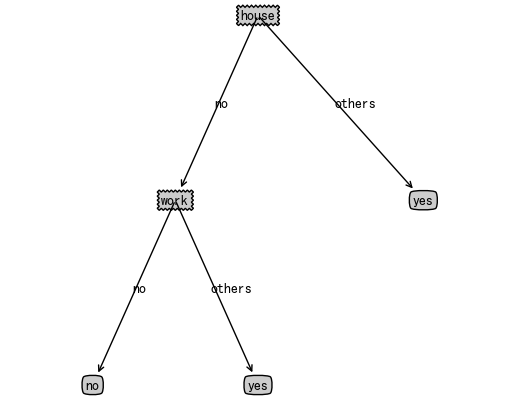

In [7]:
createPlot(cart_tree)

##### 2.测试数据2

In [8]:
data = pd.read_table("./watermelon.txt", sep=",").drop("编号",axis=1)
data['好瓜'] = data['好瓜'].apply(lambda x:'好瓜' if x == "是" else "坏瓜")
data

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,好瓜
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,好瓜
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,好瓜
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,坏瓜
9,青绿,硬挺,清脆,清晰,平坦,软粘,坏瓜


In [9]:
dataset_gua = data_to_list(data)

features_gua = list(data.columns[:-1])

In [10]:
cart_tree_gua = create_tree(dataset_gua, features_gua)
cart_tree_gua

{'纹理': {'清晰': {'触感': {'软粘': {'色泽': {'乌黑': '坏瓜',
      'others': {'根蒂': {'稍蜷': '好瓜', 'others': '坏瓜'}}}},
    'others': '好瓜'}},
  'others': {'色泽': {'乌黑': {'敲声': {'沉闷': '坏瓜', 'others': '好瓜'}},
    'others': '坏瓜'}}}}

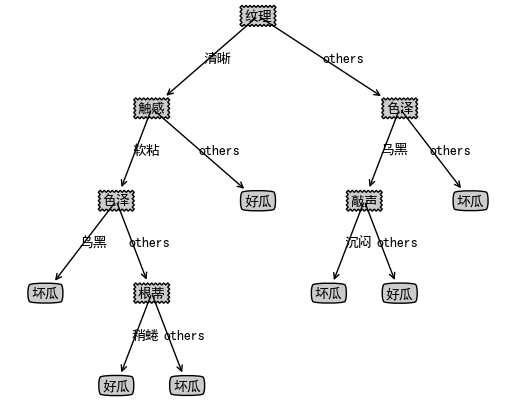

In [11]:
createPlot(cart_tree_gua)

### 二、随机森林(基于CART决策树)

In [12]:
### 构造数据子集,传入数据框，返回列表形式的数据
def get_subsample(data, label, sample_ratio, n_features):
    
    assert 0 <= sample_ratio <= 1, "抽样概率应该在0—1之间"
    assert n_features <= data.shape[1] - 1, "特征的最大数量不能超过{}个".format(data.shape[1] - 1)
    
    # 按照指定的sample_ratio随机选取数据，不放回抽样
    len_subdata = round(len(data) * sample_ratio)
    sub_dataset = data.iloc[random.sample(range(len(data)), len_subdata)]
    
    # 按照指定的n_features随机选取样本特征，不放回抽样
    drop_label_columns = data.drop(label, axis = 1).columns.to_list()
    feature_selected = random.sample(drop_label_columns, n_features)
    return feature_selected, data_to_list(sub_dataset[feature_selected + [label]])


### 建立随机森林, 传入的是数据框
def random_forest(data, label, sample_ratio, n_features, n_trees):
    trees = []
    for i in range(n_trees):
        features, data_for_tree = get_subsample(data, label, sample_ratio, n_features)
        single_tree = create_tree(data_for_tree, features)
        trees.append(single_tree)
    return trees

##### 1. 测试数据1

In [13]:
data = pd.read_table("./watermelon.txt", sep=",").drop("编号",axis=1)
data['好瓜'] = data['好瓜'].apply(lambda x:'好瓜' if x == "是" else "坏瓜")
data 

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,好瓜
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,好瓜
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,好瓜
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,坏瓜
9,青绿,硬挺,清脆,清晰,平坦,软粘,坏瓜


In [14]:
rf = random_forest(data, label="好瓜", sample_ratio = 0.7, n_features = 4, n_trees = 10)
rf

[{'纹理': {'清晰': {'触感': {'软粘': {'色泽': {'乌黑': '坏瓜', 'others': '好瓜'}},
     'others': '好瓜'}},
   'others': '坏瓜'}},
 {'脐部': {'凹陷': {'根蒂': {'蜷缩': '好瓜', 'others': '坏瓜'}},
   'others': {'色泽': {'乌黑': {'触感': {'软粘': '坏瓜', 'others': '好瓜'}},
     'others': '坏瓜'}}}},
 {'根蒂': {'蜷缩': {'脐部': {'凹陷': '好瓜', 'others': '坏瓜'}},
   'others': {'色泽': {'乌黑': {'纹理': {'清晰': '好瓜', 'others': '好瓜'}},
     'others': '坏瓜'}}}},
 {'脐部': {'平坦': '坏瓜',
   'others': {'纹理': {'清晰': {'触感': {'硬滑': '好瓜', 'others': '坏瓜'}},
     'others': {'色泽': {'乌黑': '好瓜', 'others': '坏瓜'}}}}}},
 {'脐部': {'平坦': '坏瓜',
   'others': {'色泽': {'乌黑': {'触感': {'硬滑': '好瓜', 'others': '坏瓜'}},
     'others': {'触感': {'硬滑': '坏瓜', 'others': '好瓜'}}}}}},
 {'敲声': {'浊响': {'根蒂': {'蜷缩': '好瓜',
     'others': {'脐部': {'凹陷': '坏瓜', 'others': '好瓜'}}}},
   'others': {'脐部': {'凹陷': {'色泽': {'浅白': '坏瓜', 'others': '好瓜'}},
     'others': '坏瓜'}}}},
 {'色泽': {'浅白': '坏瓜',
   'others': {'根蒂': {'硬挺': '坏瓜',
     'others': {'纹理': {'清晰': '好瓜', 'others': '好瓜'}}}}}},
 {'纹理': {'清晰': {'根蒂': {'蜷缩

In [34]:
def classify(decision_tree, features, test_example):

    first_feature = list(decision_tree.keys())[0]
    second_dict = decision_tree[first_feature]
    index_of_first_feature = features.index(first_feature)
    for key in second_dict.keys():
        if key != 'others':
            if test_example[index_of_first_feature] == key:

                if type(second_dict[key]).__name__ == 'dict':
                    classLabel = classify(second_dict[key], features, test_example)
                else:
                    classLabel = second_dict[key]

            else:
                if isinstance(second_dict['others'], str):
                    classLabel = second_dict['others']
                else:
                    classLabel = classify(second_dict['others'], features, test_example)
    return classLabel

In [ ]:
def predict(Tree, test_data):
    first_feature = list(Tree.keys())[0]
    second_dict = Tree[first_feature]
    input_first = test_data.get(first_feature)
    input_value = second_dict[input_first]
    if isinstance(input_value , dict): 
        class_label = predict(input_value, test_data)
    else:
        class_label = input_value
    return class_label


## 随机森林预测
def random_forest_predict(random_forest, test_data):
    res = []
    for tree in random_forest:
        single_tree_predict = predict(tree, test_data)
        res.append(single_tree_predict)
    predictions = max(res, key=res.count)
    return predictions  

In [15]:
### 构造决策树
def create_tree(dataset, features):
    
    # 获取传进的dataset的标签
    label_list = [example[-1] for example in dataset]
    
    # 如果标签的长度为0，也就是传进的dataset是空列表，结束程序
    if len(label_list) == 0:
        return
    
    # 标签只有一类，停止分裂
    if label_list.count(label_list[0]) == len(label_list): 
        return label_list[0]
    
    # 每条数据只剩下一个特征（数据中最后一个是标签，所以是1），停止分裂
    if len(dataset[0]) == 1:     
        return get_most_label(label_list)
    
    # 得到基尼系数最小的特征索引和对应的分裂点
    best_feature_index, best_split_point = get_best_feature(dataset)
    best_feature = features[best_feature_index]
    print("最好的特征是：", best_feature)
    
    # 初始化决策树
    Tree = {best_feature:{}}
    
    # 根据最好的特征和值，分割数据集
    sub_dataset1, sub_dataset2 = split_dataset(dataset, best_feature_index, best_split_point)  
    
    # 在sub_dataset中删掉features[best_feature_index]
    sub_dataset1 = drop_exist_feature(sub_dataset1, best_feature_index)
    sub_dataset2 = drop_exist_feature(sub_dataset2, best_feature_index)
    display("左数据集是：",sub_dataset1)
    display("右数据集是：",sub_dataset2)
    
    # 在features中删掉最好的那个特征，并赋值为sub_labels用来下一次分裂
    features.remove(best_feature)
    sub_labels1 = features[:]
    sub_labels2 = features[:]
    print("删除最好的特征后 还有：", sub_labels1, sub_labels2)
    
    print("*"*50)
    
    Tree[best_feature][best_split_point] = create_tree(sub_dataset1, sub_labels1) # 构造左子树
    print("%"*50)
    Tree[best_feature]['others'] = create_tree(sub_dataset2, sub_labels2) # 构造右子树
    return Tree

In [16]:
features = ['触感', '根蒂', '纹理', '敲声']
dataset = [['硬滑', '稍蜷', '稍糊', '浊响', '坏瓜'],
 ['硬滑', '蜷缩', '清晰', '沉闷', '好瓜'],
 ['软粘', '稍蜷', '清晰', '浊响', '好瓜'],
 ['硬滑', '稍蜷', '稍糊', '沉闷', '坏瓜'],
 ['硬滑', '蜷缩', '清晰', '浊响', '好瓜'],
 ['硬滑', '蜷缩', '清晰', '浊响', '好瓜'],
 ['软粘', '稍蜷', '清晰', '浊响', '坏瓜'],
 ['硬滑', '稍蜷', '清晰', '浊响', '好瓜'],
 ['硬滑', '蜷缩', '模糊', '浊响', '坏瓜'],
 ['硬滑', '蜷缩', '清晰', '浊响', '好瓜'],
 ['软粘', '蜷缩', '模糊', '浊响', '坏瓜'],
 ['软粘', '稍蜷', '稍糊', '浊响', '好瓜']]
create_tree(dataset, features)

最好的特征是： 纹理


'左数据集是：'

[['硬滑', '蜷缩', '沉闷', '好瓜'],
 ['软粘', '稍蜷', '浊响', '好瓜'],
 ['硬滑', '蜷缩', '浊响', '好瓜'],
 ['硬滑', '蜷缩', '浊响', '好瓜'],
 ['软粘', '稍蜷', '浊响', '坏瓜'],
 ['硬滑', '稍蜷', '浊响', '好瓜'],
 ['硬滑', '蜷缩', '浊响', '好瓜']]

'右数据集是：'

[['硬滑', '稍蜷', '浊响', '坏瓜'],
 ['硬滑', '稍蜷', '沉闷', '坏瓜'],
 ['硬滑', '蜷缩', '浊响', '坏瓜'],
 ['软粘', '蜷缩', '浊响', '坏瓜'],
 ['软粘', '稍蜷', '浊响', '好瓜']]

删除最好的特征后 还有： ['触感', '根蒂', '敲声'] ['触感', '根蒂', '敲声']
**************************************************
最好的特征是： 触感


'左数据集是：'

[['稍蜷', '浊响', '好瓜'], ['稍蜷', '浊响', '坏瓜']]

'右数据集是：'

[['蜷缩', '沉闷', '好瓜'],
 ['蜷缩', '浊响', '好瓜'],
 ['蜷缩', '浊响', '好瓜'],
 ['稍蜷', '浊响', '好瓜'],
 ['蜷缩', '浊响', '好瓜']]

删除最好的特征后 还有： ['根蒂', '敲声'] ['根蒂', '敲声']
**************************************************
最好的特征是： 根蒂


'左数据集是：'

[['浊响', '好瓜'], ['浊响', '坏瓜']]

'右数据集是：'

[]

删除最好的特征后 还有： ['敲声'] ['敲声']
**************************************************
最好的特征是： 敲声


'左数据集是：'

[['好瓜'], ['坏瓜']]

'右数据集是：'

[]

删除最好的特征后 还有： [] []
**************************************************
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
最好的特征是： 触感


'左数据集是：'

[['蜷缩', '浊响', '坏瓜'], ['稍蜷', '浊响', '好瓜']]

'右数据集是：'

[['稍蜷', '浊响', '坏瓜'], ['稍蜷', '沉闷', '坏瓜'], ['蜷缩', '浊响', '坏瓜']]

删除最好的特征后 还有： ['根蒂', '敲声'] ['根蒂', '敲声']
**************************************************
最好的特征是： 根蒂


'左数据集是：'

[['浊响', '坏瓜']]

'右数据集是：'

[['浊响', '好瓜']]

删除最好的特征后 还有： ['敲声'] ['敲声']
**************************************************
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


{'纹理': {'清晰': {'触感': {'软粘': {'根蒂': {'稍蜷': {'敲声': {'浊响': '好瓜', 'others': None}},
      'others': None}},
    'others': '好瓜'}},
  'others': {'触感': {'软粘': {'根蒂': {'蜷缩': '坏瓜', 'others': '好瓜'}},
    'others': '坏瓜'}}}}

In [17]:
features = ['敲声', '触感', '色泽']
dataset = [['浊响', '软粘', '浅白', '坏瓜'],
 ['沉闷', '硬滑', '浅白', '坏瓜'],
 ['清脆', '软粘', '青绿', '坏瓜'],
 ['浊响', '硬滑', '乌黑', '好瓜'],
 ['沉闷', '硬滑', '乌黑', '坏瓜'],
 ['浊响', '软粘', '乌黑', '坏瓜'],
 ['浊响', '硬滑', '浅白', '好瓜'],
 ['沉闷', '硬滑', '乌黑', '好瓜'],
 ['浊响', '软粘', '青绿', '好瓜'],
 ['沉闷', '硬滑', '青绿', '坏瓜'],
 ['清脆', '硬滑', '浅白', '坏瓜'],
 ['沉闷', '硬滑', '青绿', '好瓜']]

create_tree(dataset, features)

最好的特征是： 敲声


'左数据集是：'

[['软粘', '青绿', '坏瓜'], ['硬滑', '浅白', '坏瓜']]

'右数据集是：'

[['软粘', '浅白', '坏瓜'],
 ['硬滑', '浅白', '坏瓜'],
 ['硬滑', '乌黑', '好瓜'],
 ['硬滑', '乌黑', '坏瓜'],
 ['软粘', '乌黑', '坏瓜'],
 ['硬滑', '浅白', '好瓜'],
 ['硬滑', '乌黑', '好瓜'],
 ['软粘', '青绿', '好瓜'],
 ['硬滑', '青绿', '坏瓜'],
 ['硬滑', '青绿', '好瓜']]

删除最好的特征后 还有： ['触感', '色泽'] ['触感', '色泽']
**************************************************
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
最好的特征是： 触感


'左数据集是：'

[['浅白', '坏瓜'],
 ['乌黑', '好瓜'],
 ['乌黑', '坏瓜'],
 ['浅白', '好瓜'],
 ['乌黑', '好瓜'],
 ['青绿', '坏瓜'],
 ['青绿', '好瓜']]

'右数据集是：'

[['浅白', '坏瓜'], ['乌黑', '坏瓜'], ['青绿', '好瓜']]

删除最好的特征后 还有： ['色泽'] ['色泽']
**************************************************
最好的特征是： 色泽


'左数据集是：'

[['好瓜'], ['坏瓜'], ['好瓜']]

'右数据集是：'

[['坏瓜'], ['好瓜'], ['坏瓜'], ['好瓜']]

删除最好的特征后 还有： [] []
**************************************************
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
最好的特征是： 色泽


'左数据集是：'

[['好瓜']]

'右数据集是：'

[['坏瓜'], ['坏瓜']]

删除最好的特征后 还有： [] []
**************************************************
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


{'敲声': {'清脆': '坏瓜',
  'others': {'触感': {'硬滑': {'色泽': {'乌黑': '好瓜', 'others': '坏瓜'}},
    'others': {'色泽': {'青绿': '好瓜', 'others': '坏瓜'}}}}}}